In [2]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as time
from pyearth import Earth
from sklearn.model_selection import RandomizedSearchCV, KFold


In [3]:
# Loading data
X_test = pd.read_csv('data/X_test.csv')
X_train = pd.read_csv('data/X_train.csv')
y_test = pd.read_csv('data/y_test.csv')
y_train = pd.read_csv('data/y_train.csv')

Figuring out the general number of trees to use 

In [21]:
# Finding model accuracy vs number of trees
oob_rsquared = {}; test_rsquared = {}; oob_rmse = {}; test_rmse = {}

# Iterating over tree values 
for i in range(100, 1201, 50):
    model = BaggingRegressor(base_estimator = DecisionTreeRegressor(), 
                             n_estimators = i, 
                             random_state = 1,
                             n_jobs=-1,
                             oob_score = True).fit(X_train, y_train)

    oob_rsquared[i] = model.oob_score_  #Returns the out-of_bag R-squared of the model
    test_rsquared[i] = model.score(X_test, y_test) #Returns the test R-squared of the model
    oob_rmse[i] = np.sqrt(mean_squared_error(model.oob_prediction_, y_train))
    test_rmse[i] = np.sqrt(mean_squared_error(model.predict(X_test), y_test))

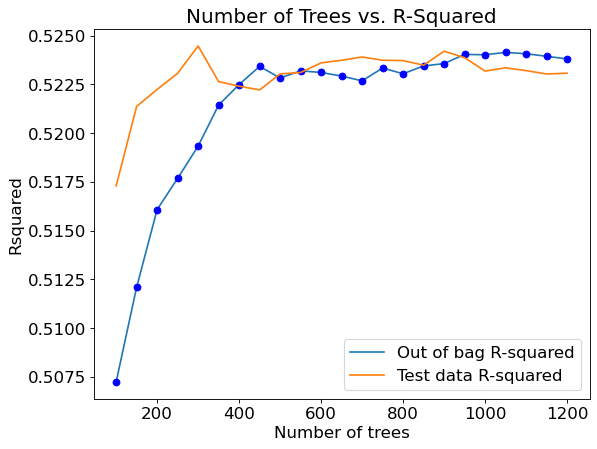

In [22]:
# Plotting 
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Number of Trees vs. R-Squared')
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),label = 'Out of bag R-squared')
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),'o',color = 'blue')
plt.plot(test_rsquared.keys(),test_rsquared.values(), label = 'Test data R-squared')
plt.xlabel('Number of trees')
plt.ylabel('Rsquared')
plt.legend()

Going to use tree values (`n_estimators`) in the range **500** to **1200**. 

In [23]:
import warnings 
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = FutureWarning)

# Optimizing hyperparameters
n_samples = X_train.shape[0]
n_features = X_train.shape[1]

params = {'estimator': [DecisionTreeRegressor(random_state = 1)],
          'n_estimators': [500, 700, 900, 1100, 1300],
          'max_samples': [0.5, 0.75, 1.0],
          'max_features': [0.5, 1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

bagging_grid = RandomizedSearchCV(BaggingRegressor(random_state = 1, n_jobs = -1),
                                       param_distributions = params,
                                       cv = cv, 
                                       n_iter = 50, 
                                       n_jobs = -1, 
                                       verbose = 1)


bagging_grid.fit(X_train, y_train.values.ravel())

print('Best R^2 Score Through Grid Search : %.3f'%bagging_grid.best_score_)
print('Best Parameters : ', bagging_grid.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best R^2 Score Through Grid Search : 0.510
Best Parameters :  {'n_estimators': 900, 'max_samples': 0.75, 'max_features': 1.0, 'estimator': DecisionTreeRegressor(random_state=1), 'bootstrap_features': True, 'bootstrap': False}


In [24]:
# Defining the initial base model 
bagging_init = BaggingRegressor(random_state = 1, 
                                 n_jobs = -1,
                                 estimator = DecisionTreeRegressor(random_state = 1),
                                 n_estimators = 900, 
                                 max_samples = 0.75, 
                                 max_features = 1.0,
                                 bootstrap_features = True, 
                                 bootstrap = False)
bagging_init.fit(X_train, y_train)

BaggingRegressor(bootstrap=False, bootstrap_features=True,
                 estimator=DecisionTreeRegressor(random_state=1),
                 max_samples=0.75, n_estimators=900, n_jobs=-1, random_state=1)

In [25]:
# Making predictions
pred_init = bagging_init.predict(X_test)

# Rounding predictions to the nearest integer 
rounded_pred_init = [round(p) for p in pred_init]

# Printing the test RMSE of the coarse grid tuning model
print("Coarse Grid Tuning Bagging Model Test RMSE:", np.sqrt(mean_squared_error(y_test, rounded_pred_init)))

Coarse Grid Tuning Bagging Model Test RMSE: 0.6673714223613529


Now for a finer grid search with `GridSearchCV()`

In [27]:
import warnings 
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = FutureWarning)

# Optimizing hyperparameters
n_samples = X_train.shape[0]
n_features = X_train.shape[1]

params = {'estimator': [DecisionTreeRegressor(random_state = 1)],
          'n_estimators': range(700, 1101, 50),
          'max_samples': [0.5, 0.75, 1.0],
          'max_features': [0.5, 1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

bagging_grid = GridSearchCV(BaggingRegressor(random_state = 1, n_jobs = -1),
                            param_grid = params,
                            cv = cv, 
                            scoring = "neg_mean_squared_error",
                            n_jobs = -1, 
                            verbose = 1)


bagging_grid.fit(X_train, y_train.values.ravel())

print('Best Score Through Grid Search : %.3f'%bagging_grid.best_score_)
print('Best Parameters : ', bagging_grid.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:
# Defining the optimized base model 
bagging_opt = BaggingRegressor(random_state = 1, 
                                n_jobs = -1,
                                estimator = DecisionTreeRegressor(random_state = 1),
                                n_estimators = 900, 
                                max_samples = 0.75, 
                                max_features = 1.0,
                                bootstrap_features = True, 
                                bootstrap = False)
bagging_opt.fit(X_train, y_train)

In [ ]:
# Making predictions
pred_opt = bagging_opt.predict(X_test)

# Rounding predictions to the nearest integer 
rounded_pred_opt = [round(p) for p in pred_opt]

# Printing the test RMSE of the coarse grid tuning model
print("Coarse Grid Tuning Bagging Model Test RMSE:", np.sqrt(mean_squared_error(y_test, rounded_pred_opt)))